<a href="https://colab.research.google.com/github/tea596933/DeepLearningwithPython/blob/master/MSVD_tensorflow_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLDS hw2: Video Captioning by RNN

Set up connection from colab to my Google Drive.

In [0]:
!pip install -U -q PyDrive ## Have to install for every colab session
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Upload data (MSVD dataset) to colab from my Google Drive, and extract it.

In [0]:
import tarfile

tar_import = drive.CreateFile({'id':'1CBPoo486Rphn2j79B_7HHonwQ--RBAqD'})
tar_import.GetContentFile('MSVD.tar')

tar = tarfile.open('MSVD.tar')
tar.extractall()
tar.close()

In [0]:
# Check whether data has been uploaded successfully
import os
os.listdir()

In [0]:
import numpy as np
import tensorflow as tf
import random
import os
import re
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

tf.reset_default_graph()
sess = tf.InteractiveSession()

Using TensorFlow backend.


## Step 1. Load & Preprocess dataset
1. Dataset: MSVD 
  - 1450 videos for training
  - 100 videos for testing
  - Each video input has been transformed into frame embeddings (80 frames * 4096) by VGG-19.
  
2. Preprocess label (Sentences)
  - Each video has several different descriptions in this dataset.
  - Discard words with text frequency <= 3, following the offered baseline of the homework slide.
  - Pad word sentences to the same length ```maxlen``` (20) using word index ```1```.
  - Words will be indexed larger than 1. 



In [0]:
#vocab_size = 6016  # For debugging. Comment it when finish debugging

EOS = 1
input_embedding_size = 4096
encoder_hidden_units = 100
decoder_hidden_units = 100
batchSize = 64
maxlen = 20

In [0]:
def tokenize(dtrain_label_word, wordCnt_lowerBdd=3):
    wordList = {}
    distinctWordCnt = 0
    tokenized_sentences = []
    existSet = set()
    
    for word_seq in dtrain_label_word:
        word_seq_ = re.sub('[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', word_seq)
        word_seq_ = word_seq_.lower()
        split_words = word_seq_.split(' ')
        for word in split_words:
            if word in existSet:
                wordList[word]['count'] += 1
            else:
                distinctWordCnt += 1
                wordList[word] = {
                    'count': 1,
                    'index': distinctWordCnt + 1
                }
                existSet.add(word)
        tokenized_sentences.append(split_words)

    wordList = {key: value['index'] for key, value in wordList.items() if value['count'] > wordCnt_lowerBdd}
    existSet = set([key for key,_ in wordList.items()])

    wordList_ordered = {word: (idx+2) for idx, (word,_) in enumerate(wordList.items())}        
        
    for iWord_seq in range(len(tokenized_sentences)):
        dataIn = []
        for word in tokenized_sentences[iWord_seq]:
            if word in existSet:
                dataIn.append(wordList_ordered[word])
        tokenized_sentences[iWord_seq] = dataIn
        
    
    return tokenized_sentences, wordList_ordered, existSet


In [0]:
dtrain_feat_path = os.listdir('MSVD/training_data/feat')
dtrain_feat_raw = []
for path in dtrain_feat_path:
    dataIn = np.load('MSVD/training_data/feat/'+path)
    dtrain_feat_raw.append(dataIn)
dtrain_label_raw = pd.read_json('MSVD/training_label.json')

dtrain_name = [re.sub('.npy$','',x) for x in dtrain_feat_path]

dtrain_feat = []
dtrain_label_word = []
for i, feat in enumerate(dtrain_feat_raw):
    filename = dtrain_name[i]
    labels = dtrain_label_raw.loc[dtrain_label_raw.id==filename].caption.iloc[0]
    for label in labels:
        dtrain_feat.append(feat)
        dtrain_label_word.append(label)

dtrain_label, wordList, existSet = tokenize(dtrain_label_word, 3)        
        
vocab_size = len(existSet)
dtrain_label = pad_sequences(dtrain_label, 
                             maxlen=maxlen, 
                             padding='post',
                             value=EOS)

## Step 2. Build TensorFlow Model (Graph)
Use LSTM encoder & LSTM decoder to build the following model.
1. Encoder Setting
  - ```encoder_inputs```: batch of embeddings of video frames (from ```dtrain_feat```)
  - ```encoder_cell```: LSTM cell with #units = ```encoder_hidden_units```
  - ```encoder_state```: init LSTM state with zeros.
  
2. Decoder Setting
  - ```decoder_inputs```: batch of sentences (from ```dtrain_label```) start from 0, meaning start of sentence.
  - ```decoder_targets```: batch of sentences (from ```dtrain_label```) start from the first word of each sentence.
  - ```decoder_input_oh``` & ```decoder_output_oh```: transform word index(e.g. ```1```) into one-hot encoding(e.g. ```[0,1,0,0,...]```).
  - ```decoder_targets```: batch of sentences (from ```dtrain_label```) start from the first word of each sentence.
  - ```encoder_cell```: LSTM cell with #units = ```encoder_hidden_units```
  - ```encoder_state```: init LSTM state with zeros.

3. 

In [0]:
encoder_inputs = tf.placeholder(shape=(None, 80, input_embedding_size), dtype=tf.float32, name='encoder_inputs')
decoder_inputs = tf.placeholder(shape=(None, maxlen), dtype=tf.int32, name='decoder_inputs')
decoder_targets = tf.placeholder(shape=(None, maxlen), dtype=tf.int32, name='decoder_targets')

### Encoder

The centerpiece of all things RNN in TensorFlow is `RNNCell` class and its descendants (like `LSTMCell`). But they are outside of the scope of this post — nice [official tutorial](https://www.tensorflow.org/tutorials/recurrent/) is available. 

`@TODO: RNNCell as a factory`

In [0]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units, state_is_tuple=False)
#print(encoder_cell.state_size)
#init_state = tf.placeholder(shape=(None, encoder_cell.state_size), dtype=tf.float32, name='init_state')
encoder_state = tf.zeros([batchSize, encoder_cell.state_size], dtype=tf.float32)

for i in range(80):
    with tf.variable_scope("encoder",reuse=(i!=0)):
        encoder_outputs, encoder_state = encoder_cell(encoder_inputs[:,i,:], encoder_state)

#del encoder_outputs


TensorFlow LSTM implementation stores state as a tuple of tensors. 
- `encoder_final_state.h` is activations of hidden layer of LSTM cell
- `encoder_final_state.c` is final output, which can potentially be transfromed with some wrapper `@TODO: check correctness`

### Decoder

In [0]:
decoder_input_oh = tf.one_hot(decoder_inputs, vocab_size+2, on_value=1.0, off_value=0.0, axis=-1)
#decoder_input_oh.shape
decoder_target_oh = tf.one_hot(decoder_targets, vocab_size+2, on_value=1.0, off_value=0.0, axis=-1)

In [0]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units, state_is_tuple=False)
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size+2], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size+2]), dtype=tf.float32)

embed_w = tf.Variable(tf.random_uniform([vocab_size+2, decoder_hidden_units], -1, 1), dtype=tf.float32)
embed_b  = tf.Variable(tf.zeros([decoder_hidden_units]), dtype=tf.float32)

pred_probs = []
loss = 0.0

decoder_state = encoder_state
print('encoder state shape: ', encoder_state.shape)
print('decoder state shape: ',decoder_state.shape)


for i in range(maxlen):
    decoder_input_embed = tf.nn.xw_plus_b(decoder_input_oh[:,i,:], embed_w, embed_b)

    with tf.variable_scope("decoder",reuse=(i!=0)):
        #decoder_output, decoder_state = decoder_cell(decoder_input_oh[:,i,:], decoder_state)
        decoder_output, decoder_state = decoder_cell(decoder_input_embed, decoder_state)
        ### calculate loss ### 
        # create answer 
        answer_in_onehot = decoder_target_oh[:,i]
#         answer_index_in_vocab = decoder_targets[:,i]
#         answer_index_in_vocab = tf.expand_dims(answer_index_in_vocab, 1)
#         batch_index	= tf.expand_dims(tf.range(0, batchSize, 1), 1)
#         sparse_mat 	= tf.concat([batch_index, answer_index_in_vocab], 1)
#         answer_in_onehot = tf.sparse_to_dense(sparse_mat, tf.stack([batchSize, vocab_size+2]), 1.0, 0.0)

        # acquire output
        logits = tf.nn.xw_plus_b(decoder_output, W, b)
        decoder_prediction = tf.argmax(logits, 1)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=answer_in_onehot)
        #cross_entropy = cross_entropy * self.caption_mask[:,i]

    pred_probs.append(logits)
    this_loss = tf.reduce_mean(cross_entropy)
    loss = loss + this_loss

encoder state shape:  (64, 200)
decoder state shape:  (64, 200)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Optimizer

In [0]:
loss

<tf.Tensor 'add_19:0' shape=() dtype=float32>

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [0]:
train_op = tf.train.AdamOptimizer().minimize(loss)

In [0]:
sess.run(tf.global_variables_initializer())

### Test forward pass

Did I say that deep learning is a game of shapes? When building a Graph, TF will throw errors when static shapes are not matching. However, mismatches between dynamic shapes are often only discovered when we try to run something through the graph.


So let's try running something. For that we need to prepare values we will feed into placeholders.

In [0]:
rand_inds = random.sample(range(len(dtrain_feat)), batchSize)
encoder_input_data = [dtrain_feat[i] for i in rand_inds]
encoder_input_data = np.array(encoder_input_data, dtype='float32')
            
din_ = np.zeros(shape=(batchSize, maxlen), dtype=np.int32)

pred_ = sess.run(logits,
    feed_dict={
        encoder_inputs: encoder_input_data,
        decoder_inputs: din_,
        decoder_targets: din_
    })
print('decoder predictions:\n' + str(pred_))
print(pred_.shape)

decoder predictions:
[[-0.19776438  0.29026493  0.12567572 ...  0.04694255 -0.12126266
  -0.14837316]
 [-0.19768818  0.29023704  0.12576102 ...  0.04698886 -0.12125028
  -0.14843422]
 [-0.1977036   0.29024327  0.12570518 ...  0.04695785 -0.12126548
  -0.14843154]
 ...
 [-0.19775361  0.29023373  0.12569948 ...  0.04686578 -0.12129899
  -0.14832814]
 [-0.19769567  0.2902351   0.12563488 ...  0.04693524 -0.12134545
  -0.14843549]
 [-0.19774145  0.29022014  0.12571456 ...  0.04694584 -0.12128685
  -0.14840095]]
(64, 6018)


Successful forward computation, everything is wired correctly.

## Training on the toy task

We will teach our model to memorize and reproduce input sequence. Sequences will be random, with varying length.

Since random sequences do not contain any structure, model will not be able to exploit any patterns in data. It will simply encode sequence in a thought vector, then decode from it.

In [0]:
def next_feed():
    rand_inds = random.sample(range(len(dtrain_feat)), batchSize)
    encoder_input_data = [dtrain_feat[i] for i in rand_inds]
    encoder_input_data = np.array(encoder_input_data, dtype='float32')
    decoder_input_data = np.zeros((batchSize, maxlen), dtype='float32')
    decoder_target_data = np.zeros((batchSize, maxlen), dtype='float32')

    dtrain_label_batch = [dtrain_label[i] for i in rand_inds]        
    for i, target_text in enumerate(dtrain_label_batch):
        for t, word_index in enumerate(target_text):
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t] = word_index
            if t < len(target_text)-1:
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t + 1] = word_index

    encoder_inputs_ = encoder_input_data
    decoder_targets_ = decoder_target_data
    decoder_inputs_ = decoder_input_data
        
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_
    }

In [0]:
loss_track = []

In [0]:
batches_in_epoch = (len(dtrain_label) // 64) + 1
#epochs = 5
epochs = 100
max_batches = batches_in_epoch * epochs
epochCnt = 0

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            #print('batch {}'.format(batch))
            print('epoch {}'.format(epochCnt))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            #predict_ = sess.run(decoder_prediction, fd)
            #for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                #print('  sample {}:'.format(i + 1))
                #print('    input     > {}'.format(inp))
                #print('    predicted > {}'.format(pred))
                #if i >= 2:
                    #break
            print()
            epochCnt += 1
except KeyboardInterrupt:
    print('training interrupted')

epoch 0
  minibatch loss: 118.87995147705078

epoch 1
  minibatch loss: 28.304059982299805

epoch 2
  minibatch loss: 24.055269241333008

epoch 3
  minibatch loss: 21.749479293823242

epoch 4
  minibatch loss: 19.73598861694336

epoch 5
  minibatch loss: 16.214265823364258

epoch 6
  minibatch loss: 16.377849578857422

epoch 7
  minibatch loss: 15.191335678100586

epoch 8
  minibatch loss: 13.078781127929688

epoch 9
  minibatch loss: 13.027229309082031

epoch 10
  minibatch loss: 15.775493621826172

epoch 11
  minibatch loss: 12.20848560333252

epoch 12
  minibatch loss: 14.183123588562012

epoch 13
  minibatch loss: 12.694012641906738

epoch 14
  minibatch loss: 13.205793380737305

epoch 15
  minibatch loss: 13.154470443725586

epoch 16
  minibatch loss: 9.485584259033203

epoch 17
  minibatch loss: 11.962868690490723

epoch 18
  minibatch loss: 10.615108489990234

epoch 19
  minibatch loss: 9.792715072631836

epoch 20
  minibatch loss: 13.019918441772461

epoch 21
  minibatch loss: 

loss 4.7188 after 2425600 examples (batch_size=64)


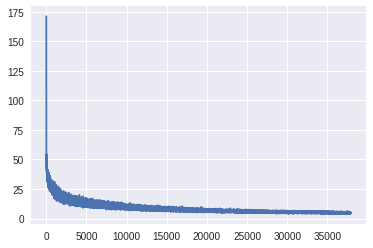

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batchSize, batchSize))

In [0]:
# Save the model
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, and save the
# variables to disk.
if os.path.exists('model') is False:
    os.mkdir('model')
save_path = saver.save(sess, "model/model_embed_100epoch_100.ckpt")
#save_path = saver.save(sess, "model/model_test.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: model/model_embed_100epoch_100.ckpt


In [0]:
!tar -jcv -f model_embed_100_100.tar.bz2 model/

model/
model/checkpoint
model/model_embed_200epoch_256.ckpt.data-00000-of-00001
model/model_embed_200epoch_256.ckpt.index
model/model_embed_200epoch_256.ckpt.meta


In [0]:
from google.colab import files
files.download('model_embed_100_100.tar.bz2')

In [0]:
index_list = []
for char, i in wordList.items():
    index_list.append(i)
print(index_list)
print(vocab_size)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199, 201, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245